In [1]:
import os
import pandas as pd
import numpy as np
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/Bus-Capstone')
import ttools #homemade module
import gtfs #homemade module
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')
%matplotlib inline

In [2]:
# get all the schedule data. (subset can be created later)
trips = gtfs.load_trips('gtfs_nov15/')
stops = gtfs.load_stops('gtfs_nov15/')
stop_times, tz_sched = gtfs.load_stop_times('gtfs_nov15/')
tcal = gtfs.TransitCalendar('gtfs_nov15/')
print 'Finished loading GTFS data.'

Finished loading GTFS data.


# get the sample of parsed AVL data.
Clean MTA prefixes from trip_id

In [3]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('spark_parse/1203.txt',header=None)

# beware!  Bonan is still working on organizing the extract files.  these columns may change.
bustime.columns = ['route','lat','lon','timestamp','vehicle_id','trip_id','trip_date','shape_id',
                   'next_stop_id','dist_from_stop','stop_dist_on_trip','presentable_dist']

bustime.drop_duplicates(['vehicle_id','timestamp'],inplace=True)
bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')
bustime.set_index(['route','trip_id','trip_date','vehicle_id'],inplace=True,drop=True)

In [4]:
# for demonstration, use a subset. Just get data for one trip-date.
tripDateLookup = "2015-12-03" # this is a non-holiday Monday
bustime = bustime.xs((tripDateLookup),level=(2),drop_level=False)
bustime.sort_index(inplace=True)
print 'Finished loading BusTime data and and slicing one day.'

Finished loading BusTime data and and slicing one day.


In [5]:
# make a separate column with just the hour, to show distribution without parsing numerically
# bustime['timestamp_hour'] = bustime['timestamp'].str[11:13]
# bustime.groupby('timestamp_hour').size()

## Compare list of trip_id between GTFS schedule and BusTime reported data.
First just compare the length of the lists.

In [6]:
# Filter the service_ids for those applicable to this date
# gtfs.TransitCalendar class now correctly adjusts for exception dates
active_services = tcal.get_service_ids('2015-12-03') 
# Load a sepate trips dataframe but use only one index level
trips_ = gtfs.load_trips('gtfs_nov15/').reset_index().set_index(['service_id'])
# Generate list of all trip_ids that are scheduled for those service_ids
gtfs_trip_ids = trips_.loc[active_services]['trip_id'].unique()
# Generate list of all trip_ids in BusTime subset
bustime_trip_ids = bustime.index.get_level_values(1).unique()

In [7]:
len(gtfs_trip_ids)

54272

In [8]:
len(bustime_trip_ids)

51637

## There appears to be a big difference in the trip_id lists.
Return the non-matching trip_ids and describe a few things about those trips, based on the GTFS data.

In [20]:
# parse times into numeric
ts_parsed = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2015-12-03')

### Plot distribution of BusTime pings throughout the day.  Look for sudden dips (gaps).

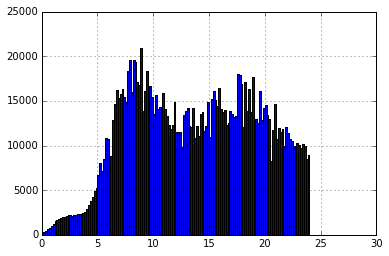

In [21]:
(ts_parsed/ttools.datetime.timedelta(hours=1)).hist(range=(0,30),bins=180)

There appears to major gaps in the mid-morning and mid-afternoon windows.
### Get the trip_id labels from GTFS which are not found anywhere in BusTime data

In [22]:
set1 = set(gtfs_trip_ids)
set2 = set(bustime_trip_ids)

unmatched = set1.symmetric_difference(set2) # goes both ways
len(unmatched)

2635

Show routes with percentage of trips missing any data

In [23]:
pct_missing_by_route = trips.loc[unmatched].groupby('route_id').size()/trips.groupby('route_id').size()
pct_missing_by_route.sort(ascending=False)
pct_missing_by_route

route_id
X11     0.036036
X42     0.032258
S84     0.031250
Q07     0.029874
Q49     0.029865
BX34    0.028668
Q40     0.028461
Q09     0.026354
S90     0.025862
X30     0.025424
Q06     0.024207
S96     0.023438
Q100    0.023313
QM25    0.023256
X38     0.023077
X3      0.022989
Q114    0.021807
X14     0.021583
Q39     0.021309
M21     0.021220
QM17    0.020833
Q69     0.020806
M57     0.020435
X37     0.018634
Q37     0.018494
QM4     0.018433
M8      0.018219
X2      0.018100
M35     0.017038
QM6     0.016878
          ...   
Q103         NaN
Q104         NaN
Q44          NaN
Q70          NaN
QM11         NaN
QM12         NaN
QM15         NaN
QM16         NaN
QM18         NaN
QM21         NaN
QM24         NaN
QM3          NaN
QM8          NaN
S81          NaN
S86          NaN
S89          NaN
S91          NaN
S92          NaN
S98          NaN
X15          NaN
X17          NaN
X19          NaN
X21          NaN
X22A         NaN
X28          NaN
X63          NaN
X64          NaN
X68  

### Show distribution of missing data according to the hour of service (based on stop times)
This should be roughly inverse to the data density plotted initially.

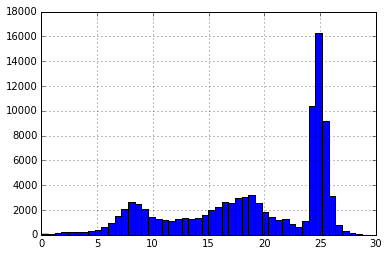

In [13]:
stop_hour = stop_times.reset_index().set_index('trip_id')['arrival_time'].apply(ttools.parseTime)/ttools.datetime.timedelta(hours=1)
stop_hour.loc[unmatched].hist(bins=48)

### Compare distributions of trip duration, all trips from GTFS versus the missing trips. 

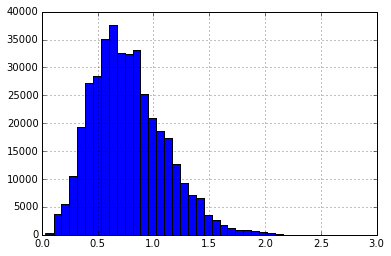

In [14]:
# Distribution of trip durations - ALL scheduled trips
pd.Series(stop_hour.groupby(level=0).max() - stop_hour.groupby(level=0).min()).hist(bins=40)

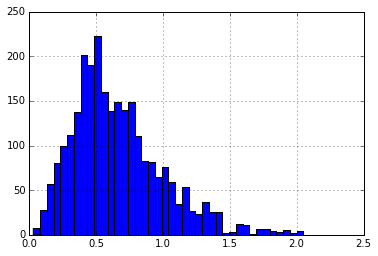

In [15]:
# Distribution of trip durations - MISSING trips only
pd.Series(stop_hour.loc[unmatched].groupby(level=0).max() - stop_hour.loc[unmatched].groupby(level=0).min()).hist(bins=40)

## Analyze expected trip data-density, but agnostic to trip_id
Plot a comparison (GTFS versus BusTime) of how many vehicles are on an active trip throughout the day.

In [16]:
start_bins = (10*stop_hour.loc[gtfs_trip_ids].groupby(level=0).min()).apply(np.floor).astype(int)
end_bins = (10*stop_hour.loc[gtfs_trip_ids].groupby(level=0).max()).apply(np.floor).astype(int)

In [17]:
# time is divided into bins of 0.1 hours (6 minutes)
# make a 2D binary matrix indicating when the trip is active during each time bin.
time_bin_matrix = np.zeros((len(start_bins),max(end_bins)+1))
counter = 0
for i,v_start in start_bins.iteritems():
    v_end = end_bins.loc[i]
    time_bin_matrix[counter,v_start:v_end] = 1
    counter += 1

Now do the same from the BusTime data.  Danger - vehicles may be recording data even when not on an active trip.

In [24]:
start_bins_bustime = (10*(ts_parsed.groupby(level=(1,3)).min()/ttools.datetime.timedelta(hours=1))).apply(np.floor).astype(int)
end_bins_bustime = (10*(ts_parsed.groupby(level=(1,3)).max()/ttools.datetime.timedelta(hours=1))).apply(np.floor).astype(int)
time_bin_matrix_bustime = np.zeros((len(start_bins_bustime),max(end_bins_bustime)+1))
counter = 0
for i,v_start in start_bins_bustime.iteritems():
    v_end = end_bins_bustime.loc[i]
    time_bin_matrix_bustime[counter,v_start:v_end] = 1
    counter += 1

### Plot the comparison.
Note that the BusTime data tracks the expected density nicely, except in two obvious periods.

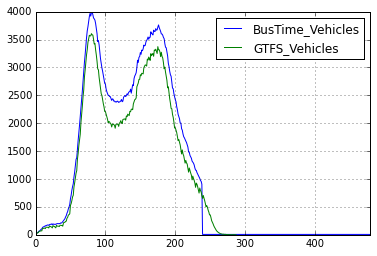

In [25]:
pd.DataFrame(time_bin_matrix_bustime.sum(axis=0),columns=['BusTime_Vehicles']).join(pd.Series(time_bin_matrix.sum(axis=0),name='GTFS_Vehicles')).plot()